In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
import os

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

import optuna
from optuna.samplers import TPESampler, RandomSampler

import ipywidgets
from tqdm import tqdm

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

In [2]:
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

biostr_df = pd.read_csv("../Data/data_BIOGRID/BIOGRID_homo_sapiens.nodes", sep=" ")
biostr_map = dict(zip(biostr_df["nodeID"], biostr_df["nodeSymbol"]))

# Dataset Loading

In [3]:
def normalize_fix_nEntr(Xi, nentr=2000):
    for i in tqdm(range(len(Xi))):
        empty_provv = np.zeros(len(Xi[0]))
        empty_provv[np.argsort(Xi[i])[-nentr:]] = Xi[i][np.argsort(Xi[i])[-nentr:]]
        n_nz = empty_provv.nonzero()[0].shape[0]
        if n_nz==nentr:
            Xi[i]=empty_provv/sum(empty_provv)
        else:
            ind_provv = np.random.choice(np.where(empty_provv==0)[0], nentr-n_nz, replace=False)
            vals = np.random.rand(nentr-n_nz)
            vals = vals/sum(vals)*0.1
            Xi[i]=empty_provv/sum(empty_provv)*0.9
            Xi[i][ind_provv] = vals
    return Xi

In [4]:
index_paths = np.loadtxt("../Data/ClassificationDataALL_4vir/topology_coex/names.txt", dtype=str)

#training samples
print("Loading Train and Val")
X = []
for t in ["n","n1o"]:
    for i in tqdm(range(3000)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X.append(np.loadtxt("../Data/ClassificationDataALL_4vir/topology_coex/"+t+"/"+str(i)+".txt"))
X=np.array(X)

#training samples labels
label_dict = dict(zip(["n","n1o"], [0,1]))

y = []
for t in ["n","n1o"]:
    y.append([label_dict[t]]*3000)#len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)))

y = np.concatenate(y)



Loading Train and Val


100%|███████████████████████████████████████| 3000/3000 [00:40<00:00, 74.70it/s]


In [5]:
X = normalize_fix_nEntr(X, nentr=500)

100%|█████████████████████████████████████| 6000/6000 [00:04<00:00, 1218.31it/s]


# Dataset and Dataloaders Definition

In [6]:
class AdjacencyDataset(Dataset):
    """Apples Dataset"""

    def __init__(self, X, y=None, test=False):
        """
        Args:
        """
        self.test = test
        self.data = X
        self.labels = y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dat = self.data[idx]#np.array([self.data[idx].nonzero()[0], self.data[idx][self.data[idx].nonzero()[0]]])
        if self.test:
            return torch.from_numpy(dat).type(torch.FloatTensor)
        else:
            return [torch.from_numpy(dat).type(torch.FloatTensor), int(self.labels[idx])]
        

# Model

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=4499, out_features=2)

    def forward(self, x):
        x=self.lin1(x)
        return x

model1 = Model()
model1=model1.cpu()


In [8]:
def set_up_trial(X, ind):
    index_rem = np.loadtxt(index_paths[ind], dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]
    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)
    
    mydat_train = AdjacencyDataset(X_train, y_train)
    mydat_val = AdjacencyDataset(X_val, y_val)
    mydat_test = AdjacencyDataset(X_test, y_test)

    train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)
     
    check_last = ModelCheckpoint('checkpoints/check_last_coex_'+str(i)+'.pth')
    
    model = Model()
    model = model1.cpu()
    
    trial_now = Trial(model,
                      optim.Adam(model1.parameters(), lr=5e-04), 
                      nn.CrossEntropyLoss(), 
                      metrics=["loss", "acc"],
                      callbacks=[check_last])
    
    trial_now = trial_now.load_state_dict(state_dict=torch.load("checkpoints/check_last_coex_"+str(ind)+".pth"))
   
    trial_now.with_generators(train_generator=train_dataloader, 
                              val_generator=val_dataloader, 
                              test_generator=test_dataloader)
    
    my_trial_now = trial_now.run(epochs=200, verbose=1)
    
    return trial_now, my_trial_now

In [20]:
trial, mytrial = set_up_trial(X, 1)

100%|##########| 200/200 [00:00<?, ?it/s]

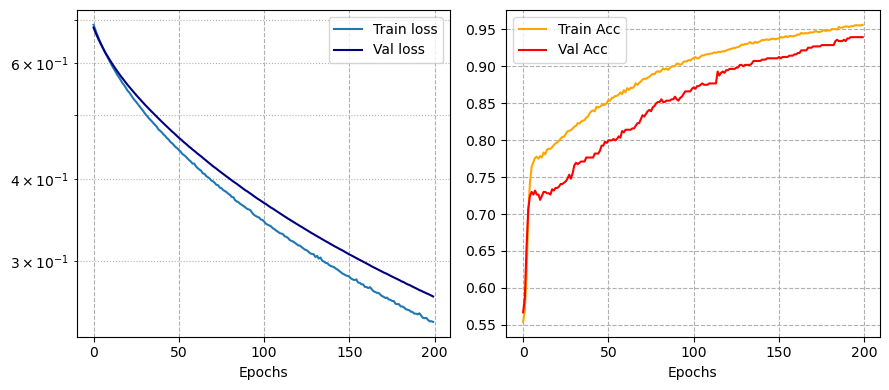

In [21]:
__, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].semilogy([mt["loss"] for mt in mytrial], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mytrial], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]
ax[0].grid(which="minor", ls=":")
plt.tight_layout()

In [11]:
def plot_confusion_matrix(trial, which="val"):
    if which=="val":
        val_pred=np.argmax(trial.predict(data_key=torchbearer.VALIDATION_DATA).detach().numpy(),axis=1)
        val_true=[v[1] for v in trial.state.data["validation_generator"].dataset]
        title="VALIDATION CONFUSION MATRIX"
    elif which=="test":
        val_pred=np.argmax(trial.predict(data_key=torchbearer.TEST_DATA).detach().numpy(),axis=1)
        val_true=[v[1] for v in trial.state.data["test_generator"].dataset]
        title="TEST CONFUSION MATRIX"
    else:
        raise ValueError("which should be either val or test")
    
    confM_val = confusion_matrix(y_true = val_true, y_pred = val_pred, labels=np.arange(2))

    plt.figure(figsize=(6,6))
    sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma")
    plt.title(title, weight="bold")
    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.tight_layout()
    
    return {"pred": val_pred, "true": np.array(val_true)}

In [24]:
coex_df = pd.read_csv("../Data/data_STRING/coexpr.nodes", sep=" ")
coex_map = dict(zip(coex_df["ID"], coex_df["Prot"]))

def plot_weights(trial, ref_df):
    weights = trial.state["model"].lin1.weight.data.detach().numpy()
    weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])
    
    weigh_df = ref_df.copy()

    for i in range(2):
        weigh_df["W"+str(i)] = weights[i]
    weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])
    
    plt.figure(figsize=(16,3))
    sns.heatmap(weights)
    plt.title("PERCEPTRON WEIGHTS HEATMAP", fontweight="bold")
    plt.xlabel("Node ID")
    plt.ylabel("Label")
    plt.tight_layout()
    
    return weigh_df

In [25]:
def plot_weights_heatmap(weigh_df):
    gauss = gaussian_kde(weigh_df[["nodeID","W1"]].T.to_numpy())
    kde = gaussian_kde(weigh_df[["nodeID","W1"]].T.to_numpy())
    density_1 = kde(weigh_df[["nodeID","W1"]].T.to_numpy())
    gauss = gaussian_kde(weigh_df[["nodeID","W0"]].T.to_numpy())
    kde = gaussian_kde(weigh_df[["nodeID","W0"]].T.to_numpy())
    density_0 = kde(weigh_df[["nodeID","W0"]].T.to_numpy())

    _, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].scatter(weigh_df["nodeID"], weights[0], c=density, cmap='viridis', s=0.1)
    ax[0].set_title("WEIGHTS LABEL 0", fontweight="bold")
    ax[0].set_xlabel("Entry position")
    ax[0].set_ylabel("Weight value")
    ax[1].scatter(weigh_df["nodeID"], weights[1], c=density, cmap='viridis', s=0.1)
    ax[1].set_title("WEIGHTS LABEL 1", fontweight="bold")
    ax[1].set_xlabel("Entry position")
    ax[1].set_ylabel("Weight value")
    plt.tight_layout()

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

0.12335958005249344

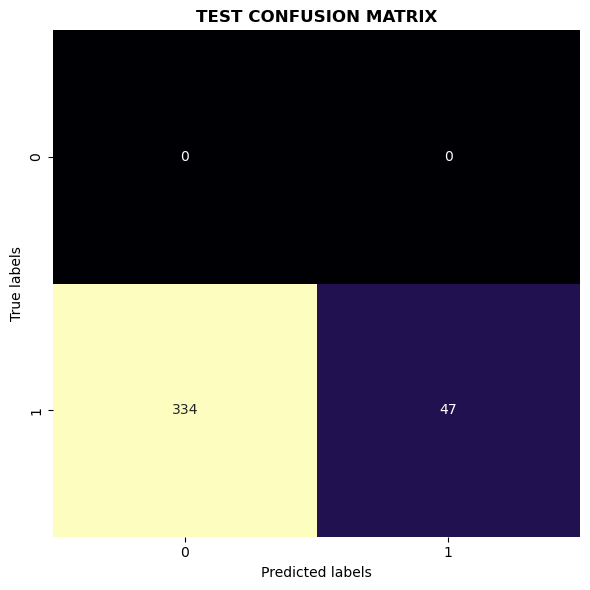

In [42]:
res_pred = plot_confusion_matrix(trial, "test")

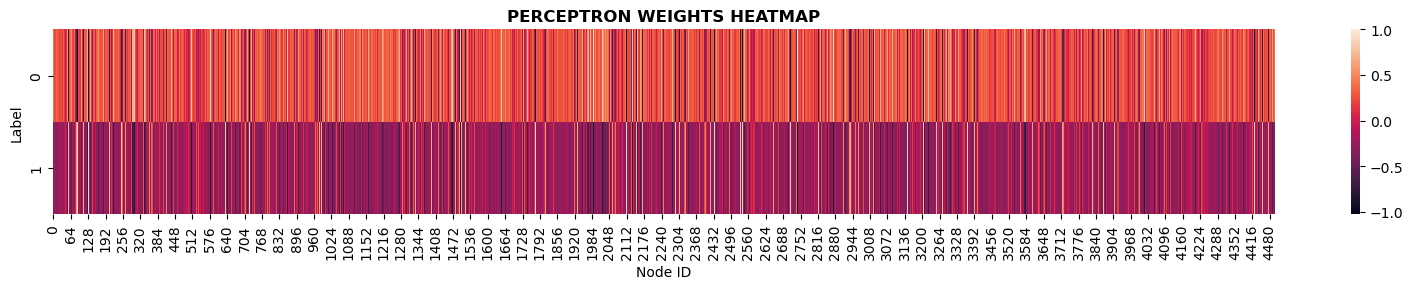

In [75]:
weigh_df = plot_weights(trial, ref_df=coex_df)

# Intersection analysis

In [16]:
def custom_intersection(arr):
    inters = np.intersect1d(arr[0],arr[1])
    for i in range(2,len(arr)):
        inters = np.intersect1d(inters, arr[i])
    return inters

In [15]:
top_50=[]
for a in [0,1,2,3,4,5,6,7]:
    top_50.append(pd.read_csv("../Data/MLRes_exp/to_100_"+index_paths[a].split("/")[-1]+".csv").to_numpy())

In [51]:
print((", ").join(custom_intersection([top_50[i][:25] for i in [1,5]])))

9606.ENSP00000215555, 9606.ENSP00000216410, 9606.ENSP00000256031, 9606.ENSP00000261401, 9606.ENSP00000295050, 9606.ENSP00000309141, 9606.ENSP00000319104, 9606.ENSP00000324804, 9606.ENSP00000327214, 9606.ENSP00000331556, 9606.ENSP00000333024, 9606.ENSP00000339182, 9606.ENSP00000340211, 9606.ENSP00000341942, 9606.ENSP00000343746, 9606.ENSP00000344562, 9606.ENSP00000363985, 9606.ENSP00000365486, 9606.ENSP00000380495, 9606.ENSP00000381237, 9606.ENSP00000403954, 9606.ENSP00000454783


# TOP 50 production

In [37]:
coex_df = pd.read_csv("../Data/data_STRING/coexpr.nodes", sep=" ")
coex_map = dict(zip(coex_df["ID"], coex_df["Prot"]))

for i in [0,1,2,3,4,5,6,7]:
    tr_now, mt_now = set_up_trial(X, i)
    weights = tr_now.state["model"].lin1.weight.detach().numpy()
    weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])

    weigh_df = coex_df.copy()

    for j in range(2):
        weigh_df["W"+str(j)] = weights[j]
    weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])

    weigh_df.sort_values("W0", ascending=False).head(50)["Prot"].to_csv("../Data/MLRes_coex/w0_100_"+index_paths[i].split("/")[-1]+".csv", index=False)
    weigh_df.sort_values("W1", ascending=False).head(50)["Prot"].to_csv("../Data/MLRes_coex/w1_100_"+index_paths[i].split("/")[-1]+".csv", index=False)

100%|##########| 200/200 [00:00<?, ?it/s]

100%|##########| 200/200 [00:00<?, ?it/s]

100%|##########| 200/200 [00:00<?, ?it/s]

100%|##########| 200/200 [00:00<?, ?it/s]

100%|##########| 200/200 [00:00<?, ?it/s]

100%|##########| 200/200 [00:00<?, ?it/s]

100%|##########| 200/200 [00:00<?, ?it/s]

100%|##########| 200/200 [00:00<?, ?it/s]

# Trials production

In [ ]:
coex_df = pd.read_csv("../Data/data_STRING/coexpr.nodes", sep=" ")
coex_map = dict(zip(coex_df["ID"], coex_df["Prot"]))

synt_pred_list, syntbstr_pred_list, test_pred_list, sars_pred_list = [],[],[],[]
top_50 = []

for i in range(len(index_paths)):
    print(index_paths[i])
    index_rem = np.loadtxt(index_paths[i], dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]

    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)

    
    mydat_train = AdjacencyDataset(X_train, y_train)
    mydat_val = AdjacencyDataset(X_val, y_val)
    mydat_test = AdjacencyDataset(X_test, y_test)

    train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)
    
    model1 = Model()
    model1 = model1.cpu()
    
    check_last = ModelCheckpoint('checkpoints/check_last_coex_'+str(i)+'.pth')

    trial_2 = Trial(model1,
                     optim.Adam(model1.parameters(), lr=5e-04), 
                     nn.CrossEntropyLoss(), 
                     metrics=["loss", "acc"],
                     callbacks=[check_last])

    trial_2.with_generators(train_generator=train_dataloader, 
                      val_generator=val_dataloader, 
                      test_generator=test_dataloader)#val67_dataloader)

    mytrial = trial_2.run(epochs=200, verbose=1)
    
    weights = model1.lin1.weight.data.detach().numpy()
    weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])
    
    weigh_df = coex_df.copy()

    for j in range(2):
        weigh_df["W"+str(j)] = weights[j]
    weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])
    
    weigh_df.sort_values("std", ascending=False).head(100)["Prot"].to_csv("../Data/MLRes_coex/to_100_"+index_paths[i].split("/")[-1]+".csv", index=False)

# Random Forest

In [100]:
def random_tree_MINE(X, ind, max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features, criterion, what_return="score"):
    num_features = X.shape[1]
    
    index_rem = np.loadtxt(index_paths[ind], dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]
    
    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)

    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth, 
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split,
                                           max_features=max_features,
                                           criterion=criterion
    )

    # Fit the classifier to the input data
    rf_classifier.fit(X_train, y_train)

    y_val_pred = rf_classifier.predict(X_val)
    y_train_pred = rf_classifier.predict(X_train)
    if what_return=="score":
        return accuracy_score(y_val, y_val_pred)
    else:
        
        # Calculate the accuracy of the model on the training data
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        # Classify the new sample
        predicted_class = rf_classifier.predict(X_test)
        
        importance_scores = rf_classifier.feature_importances_

        return {"Model": rf_classifier,
                "train_pred": y_train_pred,
                "train_true": y_train,
                "train_accuracy": train_accuracy,
                "val_pred": y_val_pred,
                "val_true": y_val,
                "val_accuracy": val_accuracy,
                "test_pred": predicted_class,
                "scores": importance_scores}

In [165]:
scores_list = []

for i in [28,43,44,67,75,77,78,90]:
    print("Random forest for", i)
    result = random_tree_MINE(X=X,
                              ind=i,
                              n_estimators=100,
                              max_depth=None, 
                              min_samples_split=2, 
                              min_samples_leaf=1,
                              max_features="sqrt",
                              criterion="entropy",
                              what_return="all")
    sars_pred = result['Model'].predict(X_pred)
    synt_pred = result['Model'].predict(X_synt)
    scores_list.append(biostr_df["nodeSymbol"][result['scores'].argsort()[::-1]][:50].to_numpy())
    print("%.3f & %.3f & %.3f & %.3f & %.3f" %(result['train_accuracy'], result['val_accuracy'], result['test_pred'].mean(), sars_pred.mean(), synt_pred.mean()))

Random forest for 28
1.000 & 0.949 & 0.974 & 0.720 & 0.820
Random forest for 43
1.000 & 0.947 & 0.838 & 0.920 & 0.780
Random forest for 44
1.000 & 0.939 & 0.906 & 0.660 & 0.490
Random forest for 67
1.000 & 0.945 & 0.978 & 0.740 & 0.660
Random forest for 75
1.000 & 0.959 & 0.873 & 0.800 & 0.580
Random forest for 77
1.000 & 0.964 & 0.890 & 0.850 & 0.700
Random forest for 78
1.000 & 0.956 & 0.442 & 0.920 & 0.830
Random forest for 90
1.000 & 0.963 & 0.890 & 0.740 & 0.830


In [ ]:
scores_df = pd.DataFrame(np.unique(np.concatenate(scores_list), return_counts=True)).T
print((", ").join(scores_df[scores_df[1]>6][0].to_numpy()))

In [102]:
y_val_pred = result["val_pred"]
y_test_pred = result["test_pred"]

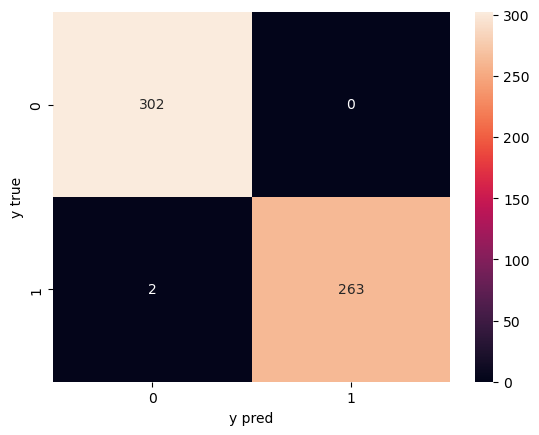

In [103]:
sns.heatmap(confusion_matrix(y_pred=result["val_pred"], y_true=result["val_true"]), annot=True, fmt="d")
plt.xlabel("y pred")
plt.ylabel("y true")
plt.show()